# Homework 3

## Course Name: Deep Learning
#### Lecturer: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Rahimi, Zahra Khoramnejad, Mehran Sarmadi

**Contact**: Ask your questions in Quera

---

**Note**: Replace the placeholders (between `## COMPLETE THE FOLLOWING SECTION  ##` and `## THE END ##`) with the appropriate details.


---
---
## 1 Introduction

In this notebook you have to design and train models for a time series prediction task on the provided dataset using these three different architectures:

- Simple RNN

- GRU

- LSTM

You will compare and rank them at the end of the notebook and explain why they were ranked that way.

---
### 1.1 Imports

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import copy

---
---
## 2 Dataset
Electric Production IP Dataset

In [4]:
df = pd.read_csv('./Electric_Production.csv', index_col='Date', parse_dates=True, dtype=np.float32)

In [3]:
df.head()

,Value
Date,
1985-01-01,72.505203
1985-02-01,70.671997
1985-03-01,62.450199
1985-04-01,57.471401
1985-05-01,55.315102


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float32
dtypes: float32(1)
memory usage: 4.7 KB


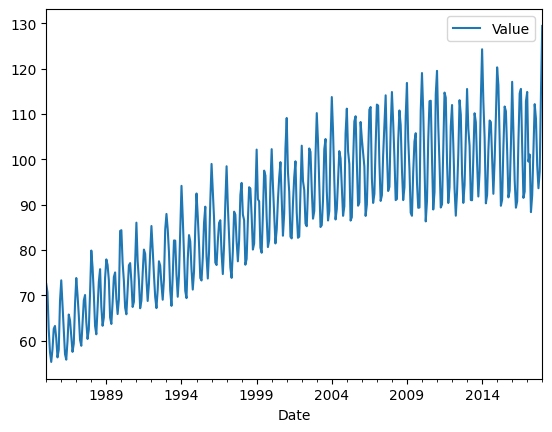

In [6]:
df.plot();

---
### 2.1 Load and prepare Dataset

In [7]:
def prepare_dataset(dataset, look_back):
    """Transform a time series data into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        look_back: Size of window for prediction
    """
    X, y = [], []
    dataset = np.array(dataset)
    data_length = len(dataset)
    for i in range(look_back, data_length):
        input = dataset[i-look_back: i]
        output = dataset[i]
        X.append(input)
        y.append(output)

    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
look_back = 60

data_length = len(df)

train_data_size = int(data_length * 0.75)
validaion_data_size = int(data_length * 0.25)


train_data = df[: train_data_size]
validation_data = df[train_data_size: ]


X_train, y_train = prepare_dataset(train_data, look_back)
X_val, y_val = prepare_dataset(validation_data, look_back)


X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)


print(  f"Shape of X_train data -> {X_train.shape} \n"
        f"Shape of y_train data -> {y_train.shape} \n"
        f"Shape of X_val data -> {X_val.shape} \n"
        f"Shape of y_val data -> {y_val.shape} \n"
    )


Shape of X_train data -> torch.Size([237, 60, 1]) 
Shape of y_train data -> torch.Size([237, 1]) 
Shape of X_val data -> torch.Size([40, 60, 1]) 
Shape of y_val data -> torch.Size([40, 1]) 



---
---
## 3 Trainer function

In [18]:
import torch
import copy

def trainer(model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs):
    early_stopping_patience = 150
    early_stopping_counter = 0

    valid_loss_min=np.inf
    best_model = copy.deepcopy(model)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()

        # Forward pass
        output_train = model(X_train)
        # Compute loss
        train_loss = criterion(output_train, y_train)
        train_losses.append(train_loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            output_val = model(X_val)
            valid_loss = criterion(output_val, y_val)
            val_losses.append(valid_loss.item())

            if valid_loss <= valid_loss_min:
                best_model = copy.deepcopy(model)
                print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).')
                valid_loss_min = valid_loss
                early_stopping_counter = 0    # Reset counter if validation loss decreases
            else:
                print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
                early_stopping_counter += 1

            if early_stopping_counter > early_stopping_patience:
                print('Early stopped at epoch :', epoch)
                break

            print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

    return best_model, train_losses, val_losses


---
---
## 4 RNN

---
### 4.1 Define single RNN cell

In [13]:
import torch.nn as nn
import numpy as np

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(RNNCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity

        # Define the layers
        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        gates = self.x2h(input) + self.h2h(hx)

        if self.nonlinearity == "tanh":
            hy = torch.tanh(gates)
        elif self.nonlinearity == "relu":
            hy = torch.relu(gates)
        else:
            raise RuntimeError(
                "Unknown nonlinearity: {}".format(self.nonlinearity))

        return hy


---
### 4.2 RNN model

In [15]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(SimpleRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bias=bias, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        out, _ = self.rnn(input, hx)

        # Only take the output from the final timestep
        out = out[:, -1, :]

        out = self.fc(out)

        return out


---
### 4.3 Train RNN model and plot losses

In [16]:
# Instantiate model
SimpleRNN_model = SimpleRNN(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
SimpleRNN_model.to(device)

SimpleRNN(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [17]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SimpleRNN_model.parameters(), lr = learning_rate)

In [19]:
SimpleRNN_best_model, train_losses, val_losses = trainer(SimpleRNN_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Streaming output truncated to the last 5000 lines.
Epoch 192: Validation loss decreased (1752.320557 --> 1735.432007).
	 Train_Loss: 829.7449 Val_Loss: 1735.4320  BEST VAL Loss: 1735.4320

Epoch 193: Validation loss decreased (1735.432007 --> 1718.722046).
	 Train_Loss: 818.8247 Val_Loss: 1718.7220  BEST VAL Loss: 1718.7220

Epoch 194: Validation loss decreased (1718.722046 --> 1702.191772).
	 Train_Loss: 808.0508 Val_Loss: 1702.1918  BEST VAL Loss: 1702.1918

Epoch 195: Validation loss decreased (1702.191772 --> 1685.838501).
	 Train_Loss: 797.4228 Val_Loss: 1685.8385  BEST VAL Loss: 1685.8385

Epoch 196: Validation loss decreased (1685.838501 --> 1669.659424).
	 Train_Loss: 786.9384 Val_Loss: 1669.6594  BEST VAL Loss: 1669.6594

Epoch 197: Validation loss decreased (1669.659424 --> 1653.655029).
	 Train_Loss: 776.5960 Val_Loss: 1653.6550  BEST VAL Loss: 1653.6550

Epoch 198: Validation loss decreased (1653.655029 --> 1637.822388).
	 Train_Loss: 766.3950 Val_Loss: 1637.8224  BEST VAL 

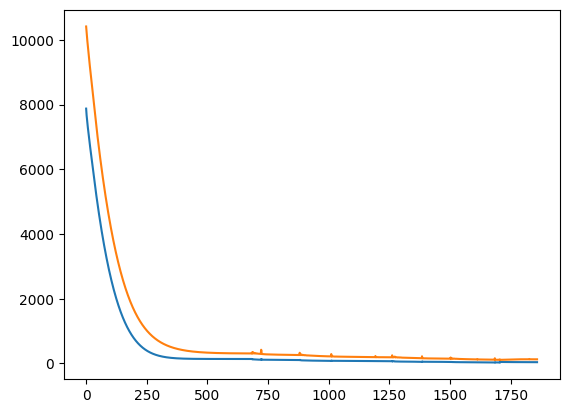

In [20]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 4.4 Evaluate model on validation data

In [21]:
val_predict_RNN = SimpleRNN_best_model(X_val)

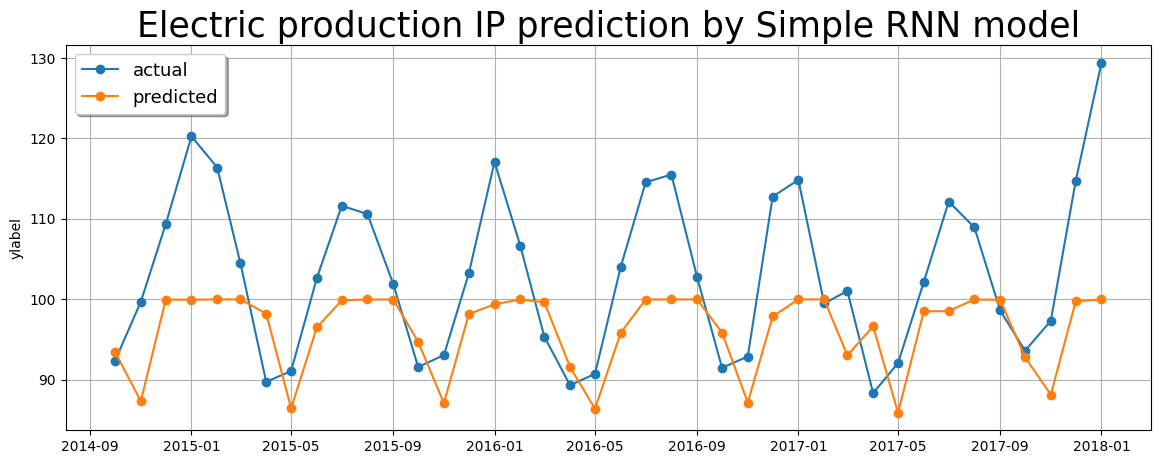

In [22]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by Simple RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 5 GRU

---
### 5.1 Define single GRU cell

In [23]:
import torch
import torch.nn as nn

class GRUCell(nn.Module):
    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(GRUCell, self).__init__()

        self.input_length = input_length
        self.hidden_size = hidden_size

        # Define the layers
        self.reset_gate = nn.Linear(input_length + hidden_size, hidden_size, bias=bias)
        self.update_gate = nn.Linear(input_length + hidden_size, hidden_size, bias=bias)
        self.output_gate = nn.Linear(input_length + hidden_size, hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, h):
        # Concatenate the input and hidden state
        combined = torch.cat((x, h), 1)

        r = torch.sigmoid(self.reset_gate(combined))

        z = torch.sigmoid(self.update_gate(combined))

        n_t = torch.tanh(self.output_gate(torch.cat((x, r * h), 1)))

        h_new = (1 - z) * n_t + z * h

        return h_new


---
### 5.2 GRU model

In [25]:
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(GRU, self).__init__()

        # Define the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, bias=bias, batch_first=True)

        # Define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        # Pass the input through the GRU layer
        out, _ = self.gru(input, hx)

        # Only take the output from the final timestep
        out = out[:, -1, :]

        # Pass the output of the last time step through the fully connected layer
        out = self.fc(out)

        return out


---
### 5.3 Train GRU model and plot losses

In [26]:
GRU_model = GRU(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
GRU_model.to(device)

GRU(
  (gru): GRU(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [27]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr = learning_rate)

In [28]:
GRU_best_model, train_losses, val_losses = trainer(GRU_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Streaming output truncated to the last 5000 lines.
Epoch 43: Validation loss decreased (7575.485840 --> 7510.373535).
	 Train_Loss: 5340.7842 Val_Loss: 7510.3735  BEST VAL Loss: 7510.3735

Epoch 44: Validation loss decreased (7510.373535 --> 7445.662598).
	 Train_Loss: 5286.4780 Val_Loss: 7445.6626  BEST VAL Loss: 7445.6626

Epoch 45: Validation loss decreased (7445.662598 --> 7381.367188).
	 Train_Loss: 5232.5527 Val_Loss: 7381.3672  BEST VAL Loss: 7381.3672

Epoch 46: Validation loss decreased (7381.367188 --> 7317.502441).
	 Train_Loss: 5179.0210 Val_Loss: 7317.5024  BEST VAL Loss: 7317.5024

Epoch 47: Validation loss decreased (7317.502441 --> 7254.078125).
	 Train_Loss: 5125.8950 Val_Loss: 7254.0781  BEST VAL Loss: 7254.0781

Epoch 48: Validation loss decreased (7254.078125 --> 7191.103027).
	 Train_Loss: 5073.1826 Val_Loss: 7191.1030  BEST VAL Loss: 7191.1030

Epoch 49: Validation loss decreased (7191.103027 --> 7128.583496).
	 Train_Loss: 5020.8896 Val_Loss: 7128.5835  BEST VAL 

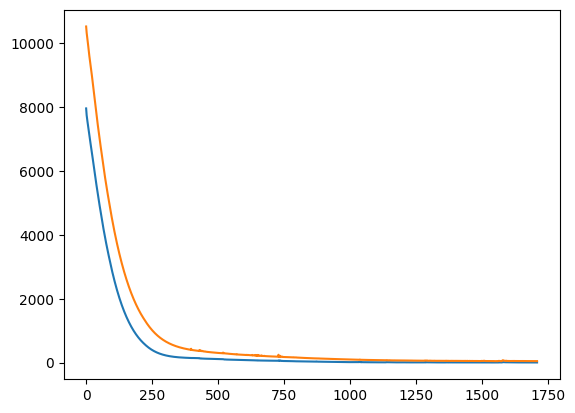

In [29]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 5.4 Evaluate model on validation data

In [30]:
val_predict_GRU = GRU_best_model(X_val)

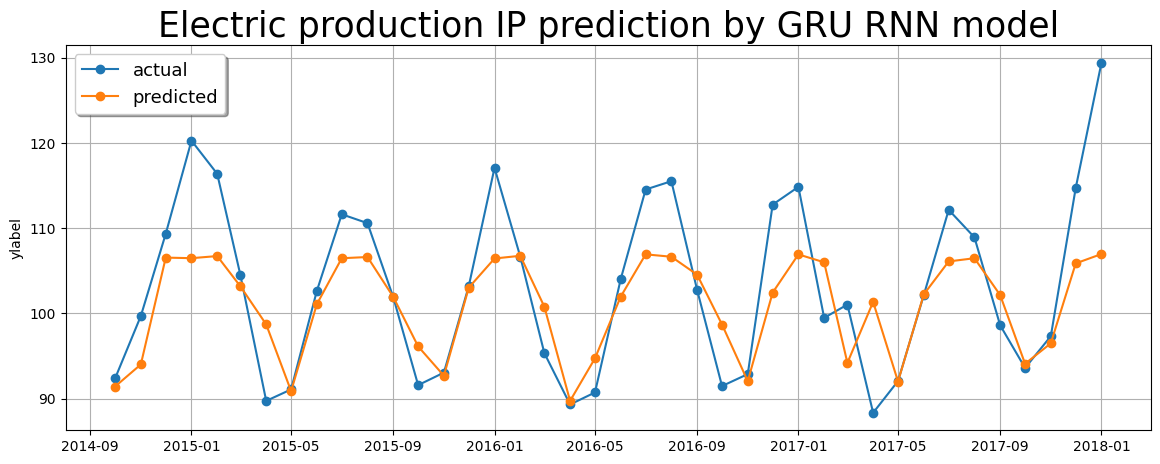

In [31]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by GRU RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 6 LSTM

---
### 6.1 Define single LSTM cell

In [32]:
import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(LSTMCell, self).__init__()

        self.input_length = input_length
        self.hidden_size = hidden_size

        # Define the layers
        self.forget_gate = nn.Linear(input_length + hidden_size, hidden_size, bias=bias)
        self.input_gate = nn.Linear(input_length + hidden_size, hidden_size, bias=bias)
        self.cell_gate = nn.Linear(input_length + hidden_size, hidden_size, bias=bias)
        self.output_gate = nn.Linear(input_length + hidden_size, hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hx=None):
        if hx is None:
            hx = x.new_zeros(x.size(0), self.hidden_size, requires_grad=False)
            cx = x.new_zeros(x.size(0), self.hidden_size, requires_grad=False)
        else:
            hx, cx = hx

        combined = torch.cat((x, hx), 1)

        # Compute the forget gate
        fg = torch.sigmoid(self.forget_gate(combined))

        # Compute the input gate
        ig = torch.sigmoid(self.input_gate(combined))

        # Compute the cell gate
        cg = torch.tanh(self.cell_gate(combined))

        # Compute the new cell state
        cx = fg * cx + ig * cg

        # Compute the output gate
        og = torch.sigmoid(self.output_gate(combined))

        # Compute the new hidden state
        hx = og * torch.tanh(cx)

        return hx, cx


---
### 6.2 LSTM model

In [33]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bias=bias, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        out, _ = self.lstm(input, hx)

        out = out[:, -1, :]

        out = self.fc(out)

        return out


---
### 6.3 Train LSTM model and plot losses

In [34]:
LSTM_model = LSTM(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
LSTM_model.to(device)

LSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [35]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr = learning_rate)

In [36]:
LSTM_best_model, train_losses, val_losses = trainer(LSTM_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Streaming output truncated to the last 5000 lines.
Epoch 52: Validation loss decreased (7490.795898 --> 7436.373535).
	 Train_Loss: 5270.1562 Val_Loss: 7436.3735  BEST VAL Loss: 7436.3735

Epoch 53: Validation loss decreased (7436.373535 --> 7382.295898).
	 Train_Loss: 5224.8135 Val_Loss: 7382.2959  BEST VAL Loss: 7382.2959

Epoch 54: Validation loss decreased (7382.295898 --> 7328.570312).
	 Train_Loss: 5179.7910 Val_Loss: 7328.5703  BEST VAL Loss: 7328.5703

Epoch 55: Validation loss decreased (7328.570312 --> 7275.200195).
	 Train_Loss: 5135.0947 Val_Loss: 7275.2002  BEST VAL Loss: 7275.2002

Epoch 56: Validation loss decreased (7275.200195 --> 7222.190430).
	 Train_Loss: 5090.7285 Val_Loss: 7222.1904  BEST VAL Loss: 7222.1904

Epoch 57: Validation loss decreased (7222.190430 --> 7169.543945).
	 Train_Loss: 5046.6943 Val_Loss: 7169.5439  BEST VAL Loss: 7169.5439

Epoch 58: Validation loss decreased (7169.543945 --> 7117.262695).
	 Train_Loss: 5002.9941 Val_Loss: 7117.2627  BEST VAL 

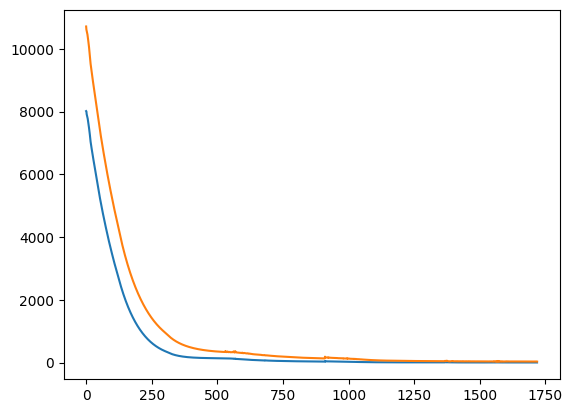

In [37]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 6.4 Evaluate model on validation data

In [38]:
val_predict_LSTM = LSTM_best_model(X_val)

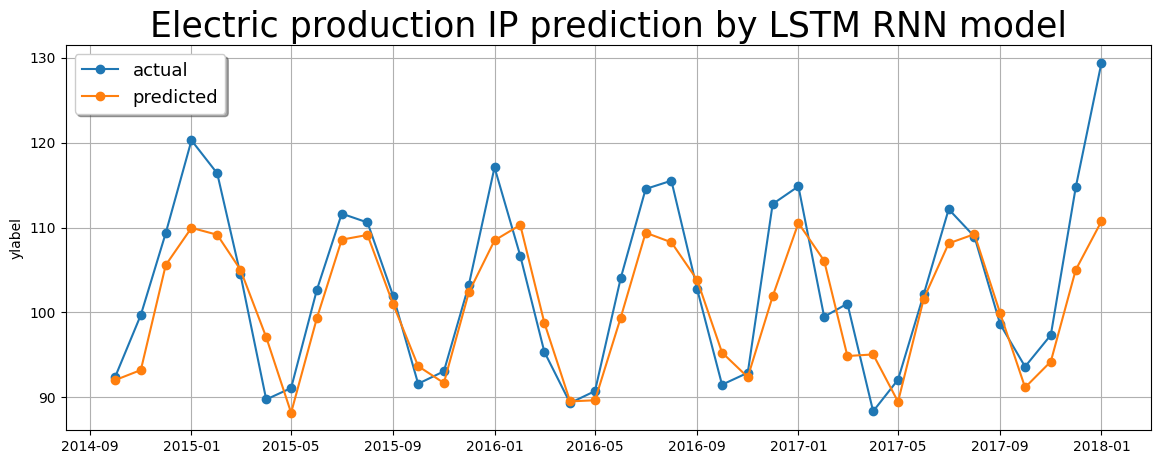

In [39]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by LSTM RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 7 Comaprison

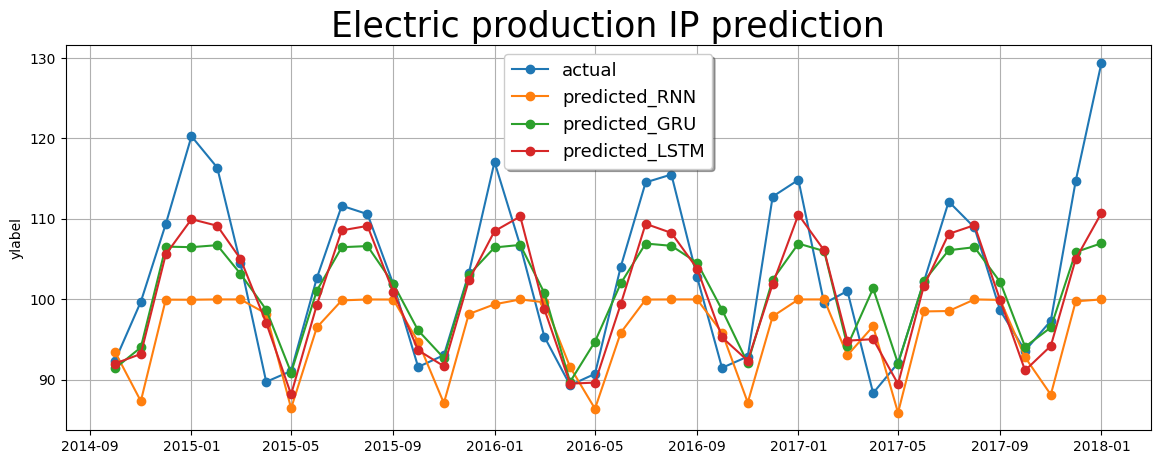

In [40]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted_RNN", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted_GRU", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted_LSTM", marker="o")
plt.title("Electric production IP prediction", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()


<b>1-Rank these architectures based on their performance?

2-Why are they ranked in this order?

3-Run the notebook again with look_back = 15.
write about the difference in the comparison plot and the possible cause for that difference.</b>


<font color='#73FF73'><b>Your answer:</b></font>

1- The performance of the three architectures, from highest to lowest, is as follows:

   1. LSTM (Long Short-Term Memory)
   2. GRU (Gated Recurrent Unit)
   3. RNN (Vanilla Recurrent Neural Network)

<hr/> 

2- The ranking of these models can be attributed to their inherent architectural differences which impact their ability to handle long-term dependencies in sequences:

   - **LSTM**: LSTMs are designed to avoid the long-term dependency problem in RNNs. They remember information for long periods of time and are therefore better suited for complex tasks that require learning long-term temporal dependencies. This is achieved through a sophisticated gate mechanism that controls the flow of information into and out of the memory cell.

   - **GRU**: GRUs, like LSTMs, also have gating mechanisms that modulate the flow of information to the hidden state. However, they have fewer gates and do not possess a separate memory cell. This makes them computationally more efficient than LSTMs but at the cost of expressive power. Therefore, while they perform better than vanilla RNNs, they may not perform as well as LSTMs for tasks requiring complex long-term dependencies.

   - **RNN**: Vanilla RNNs suffer from the vanishing gradient problem, which makes it difficult for them to learn and represent long-term dependencies in the data. This is likely why they perform worse than GRU and LSTM models, which are specifically designed to tackle this issue.

<hr/>

3- The comparison plot of the LSTM, GRU, and RNN models performance shows a difference in the accuracy of prediction on the validation data for the three models. From the training data, it is also evident that the loss values, for all three models, had noticable decrease. The reduction in the loss function indicates that the models are learning and performing better on the validation data after changing the lookback value from 60 to 15.

The improved performance with a reduced lookback value can be attributed to the nature of the data and the inherent characteristics of Recurrent Neural Networks (RNNs), including LSTM and GRU.

1. **Temporal Dependencies**: RNNs are designed to capture temporal dependencies in sequence data. The lookback period determines how many previous time steps the model considers when making a prediction. If the underlying process has short-term dependencies (i.e., future values primarily depend on recent past values), a smaller lookback period may be more appropriate. In this case, reducing the lookback value from 60 to 15 might have allowed the models to better capture the relevant short-term trends in the data.

2. **Overfitting**: A larger lookback period increases the complexity of the model as it needs to learn and remember more temporal dependencies. This could lead to overfitting, especially when the dataset is small (~400 entries), as in this case. Overfitting refers to a model that learns the training data too well, capturing noise in addition to the underlying pattern. Such a model performs poorly on unseen data. By reducing the lookback period, the model complexity was reduced, likely making it less prone to overfitting.

3. **Data Characteristics**: The 'Value' in the dataset, which probably represents electric production, might be influenced more by recent events (e.g., weather conditions, demand fluctuations) rather than events that occurred a long time ago. Therefore, a smaller lookback value that focuses on more recent data might result in better performance.

<hr/>

### Important Note
There are two versions of these notebooks, in two separate files. One executed with lookback of 60, the other with lookback of 15.